## Урок 6. Задача look-alike

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [22]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import catboost as catb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, \
                            precision_recall_curve, confusion_matrix, log_loss

import warnings
warnings.simplefilter("ignore")
pd.options.display.max_columns = 30

**1. Возьмем датасет 
Bank Marketing Data Set**

In [23]:
# Приведение типов
def astype_col(df, colgroup, coltype):
    for colname in colgroup:
        df[colname] = df[colname].astype(coltype)
    return df

# Удаление столбцов
def drop_col(df, colgroup):
    for column in colgroup:
        df = df.drop(column, axis=1)  
    return df

# Перевод категориальных признаков в dummies
def dummies_col(df, colgroup):
    for colname in colgroup:
        df = pd.concat([df, pd.get_dummies(df[colname], prefix=colname)], axis=1)
    return df

In [24]:
# Расчет метрик
def get_metrics(y_valid, preds, matrix=True):
    
    precision, recall, thresholds = precision_recall_curve(y_valid, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = round(roc_auc_score(y_valid, preds), 3)
    logloss = round(log_loss(y_valid, preds), 3)

    ix = np.argmax(fscore)
    if matrix == True:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, log-loss=%.3F' % (
                        thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss))
    
        plt.figure(figsize=(8, 6))
        font = {'size' : 12}
        plt.rc('font', **font)

        cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])
        plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
        plt.show()
    else:
        return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss

# Матрица ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
results = pd.DataFrame()
results['type'] = []
results['threshold'] = []
results['Precision'] = []
results['Recall'] = []
results['F-Score'] = []
results['roc_auc'] = []
results['log_loss'] = []

def evaluate_results(y_test, y_predict, y_predict_proba, results, stype):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict_proba)
    fscore = (2 * precision * recall) / (precision + recall)
    #print(precision, recall)
    ix = np.argmax(fscore)
    
    print('Classification results:')
    f1 = fscore[ix]
    print("f1: %.3f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict_proba)
    print("roc: %.3f%%" % (roc * 100.0)) 
    rec = recall[ix]
    print("recall: %.3f%%" % (rec * 100.0)) 
    prc = precision[ix]
    print("precision: %.3f%%" % (prc * 100.0)) 
    log = log_loss(y_test, y_predict_proba)
    print(f"log_loss: {log}")
    
    results = results.append({'type': stype, 
                'threshold': thresholds[ix],
                'Precision': prc,
                'Recall': rec,
                'F-Score': f1,
                'roc_auc': roc,
                'log_loss': log},
                ignore_index=True)
    
    plot_precision_recall(precision, recall, thresholds)
    
    return results

In [26]:
df = pd.read_csv('bank.csv', ';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [27]:
df.shape

(4521, 17)

In [28]:
df = df.rename(columns={'y': 'target'})
df['target'].unique()

array(['no', 'yes'], dtype=object)

In [29]:
df['target'] = list(map(lambda x: 0 if x=='no' else 1, df['target']))
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,0
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,0
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,0
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,0
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,0


**2.сделать feature engineering**

In [30]:
categorical_features = df.select_dtypes(include=(np.object)).columns.to_list()
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [31]:
df = dummies_col(df, categorical_features)

In [32]:
df = drop_col(df, categorical_features)

In [33]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,...,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240,0.105729,0.209246,0.037160,0.024773,0.214333,0.050874,0.040478,...,0.140013,0.004424,0.049104,0.032736,0.156160,0.117452,0.010838,0.309224,0.086043,0.017695,0.011502,0.108383,0.043574,0.028534,0.819509
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347,0.307524,0.406815,0.189174,0.155451,0.410404,0.219764,0.197099,...,0.347039,0.066372,0.216109,0.177965,0.363047,0.321994,0.103553,0.462225,0.280458,0.131856,0.106640,0.310898,0.204169,0.166510,0.384638
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


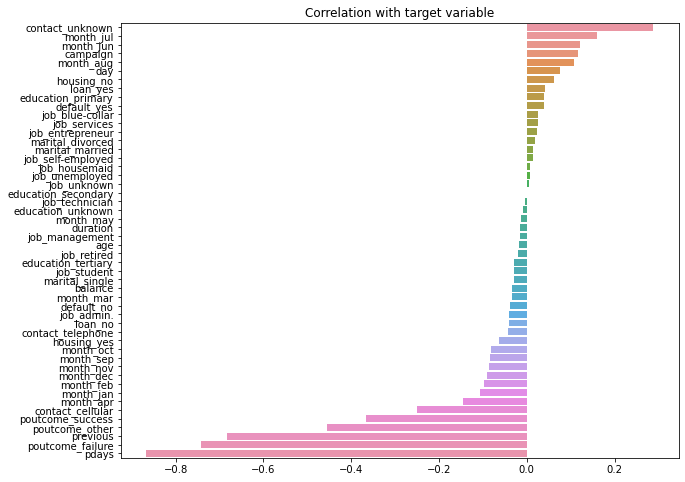

In [34]:
# Посмотрим зависимость признаков
corr_with_target = df.drop('target', axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**3.обучить любой классификатор (какой вам нравится)**

In [35]:
# Разделяем набор признаков
X = df.drop('target', axis=1)
y = df['target']

# Разбиваем выборку на трейн и на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

# Выводим результат разбиения
X_train.shape, X_test.shape

((3164, 51), (1357, 51))

In [38]:
# Рассчитываем величину дисбаланса
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance = round(disbalance, 2)
disbalance

7.67

In [39]:
# Обучим модель
model = catb.CatBoostClassifier(silent=True, 
                                     random_state=21, 
                                     class_weights=[1, disbalance],
                                     max_depth=4
                                    )

model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1:]

Best Threshold=0.735311, F-Score=0.578, Precision=0.586, Recall=0.571, Roc-AUC=0.912, log-loss=0.326
Confusion matrix, without normalization
[[1138   63]
 [  68   88]]


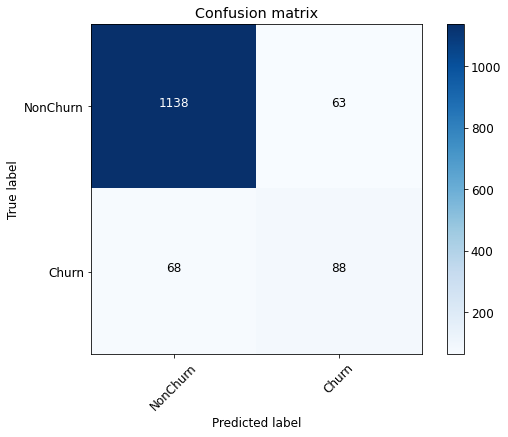

In [40]:
# Посчитаем метрики
get_metrics(y_test, preds, matrix=True)

**4.далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть**

In [41]:
def separation(coef=0.25, detail=True):
    
    mod_data = df.copy()
    pos_ind = np.where(mod_data['target'].values == 1)[0]
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(coef * len(pos_ind)))
    
    if detail == True:
        print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]

    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
    if detail == True:
        print('target variable:\n', mod_data.iloc[:,-1].value_counts())
        return mod_data
    
    else:
        val = mod_data.iloc[:,-1].value_counts()
        return mod_data, val

In [42]:
separation()

Using 131/521 as positives and unlabeling the rest
target variable:
 -1    4390
 1     131
Name: class_test, dtype: int64


,age,balance,day,duration,campaign,pdays,previous,target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,class_test
0,30,1787,19,79,1,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1
1,33,4789,11,220,1,339,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1
2,35,1350,16,185,1,330,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
3,30,1476,3,199,4,-1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-1
4,59,0,5,226,1,-1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,30,329,5,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1
4517,57,-3313,9,153,1,-1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1
4518,57,295,19,151,11,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1
4519,28,1137,6,129,4,211,3,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,-1


**5. применить random negative sampling для построения классификатора в новых условиях**

In [43]:
mod_data = separation()
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

Using 131/521 as positives and unlabeling the rest
target variable:
 -1    4390
 1     131
Name: class_test, dtype: int64
(131, 53) (131, 53)


In [44]:
def get_model(sample_train, sample_test, detail=True):
    
    X_train = sample_train.drop(['target', 'class_test'], axis=1)
    y_train = sample_train['target']
    X_test = sample_test.drop(['target', 'class_test'], axis=1)
    y_test = sample_test['target']
    
    params = {        
     'class_weights':[1, disbalance], 
#      'silent':True,
     'random_state':21,
#      'eval_metric':'F1',
     'early_stopping_rounds':20            
    }
    
    model = catb.CatBoostClassifier(**params, silent=True)

    model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)])


    preds = model.predict_proba(X_test)[:, 1:]
    
    if detail == True:
        get_metrics(y_test, preds, matrix=True)
        
    else:
        thresholds, fscore, precision, recall, roc_auc, logloss = get_metrics(y_valid, preds, detail)
        return thresholds, fscore, precision, recall, roc_auc, logloss

**6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)**

Best Threshold=0.552894, F-Score=nan, Precision=0.000, Recall=0.000, Roc-AUC=0.756, log-loss=0.734
Confusion matrix, without normalization
[[3880    0]
 [ 379    0]]


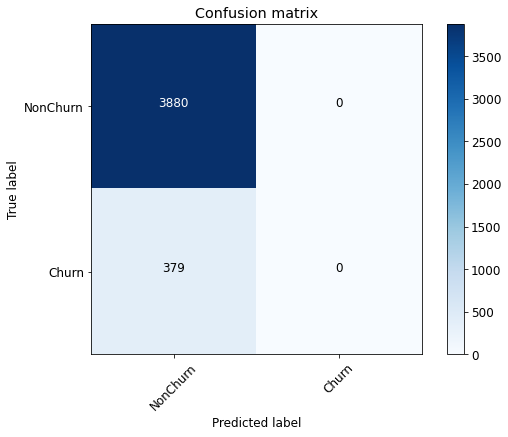

In [45]:
# Посчитаем метрики
get_model(sample_train, sample_test)